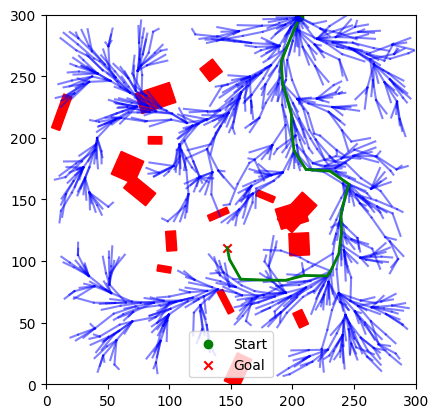

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Helper functions
def generate_obstacle(map_size, num_obstacles):
    obstacles = []
    for _ in range(num_obstacles):
        width = random.randint(5, 30)
        height = random.randint(5, 30)
        x = random.randint(0, map_size[0] - width)
        y = random.randint(0, map_size[1] - height)
        angle = random.uniform(0, 2 * np.pi)
        # (?) "pos" means the leftdown point of the obstacle
        obstacles.append({'pos': (x, y), 'size': (width, height), 'angle': angle})
    return obstacles

def check_collision(car_pos, car_size, obstacles):
    cx, cy = car_pos
    car_rect = plt.Rectangle((cx, cy), car_size[0], car_size[1], angle=0, color="blue")
    
    for obs in obstacles:
        ox, oy = obs['pos']
        ow, oh = obs['size']
        # Simplified collision check (could be extended with OBB for accuracy)
        if (cx < ox + ow and cx + car_size[0] > ox and cy < oy + oh and cy + car_size[1] > oy):
            return True
    return False

def check_collision_segment(start_pos, end_pos, car_size, obstacles):
    """Check if the line segment between start_pos and end_pos collides with any obstacles."""
    # We will discretize the line segment and check for collision at each point.
    num_steps = 100  # Number of steps to discretize the segment
    for i in range(num_steps):
        x = start_pos[0] + (end_pos[0] - start_pos[0]) * (i / num_steps)
        y = start_pos[1] + (end_pos[1] - start_pos[1]) * (i / num_steps)
        if check_collision((x, y), car_size, obstacles):
            return True
    return False

def visualize_map(map_size, obstacles, tree_nodes, path=None, start=None, goal=None):
    fig, ax = plt.subplots()
    ax.set_xlim(0, map_size[0])
    ax.set_ylim(0, map_size[1])
    ax.set_aspect('equal')

    # Plot obstacles
    for obs in obstacles:
        ox, oy = obs['pos']
        ow, oh = obs['size']
        ax.add_patch(plt.Rectangle((ox, oy), ow, oh, angle=math.degrees(obs['angle']), color='red'))

    # Plot the RRT* search tree
    for node in tree_nodes:
        if node[1] is not None:  # parent exists
            ax.plot([node[0][0], node[1][0]], [node[0][1], node[1][1]], color='blue', alpha=0.5)
    
    # Plot the path
    if path:
        path_x, path_y = zip(*path)
        ax.plot(path_x, path_y, color='green', linewidth=2)

    # Mark the start and goal
    if start:
        ax.scatter(start[0], start[1], color='green', marker='o', label='Start')
    if goal:
        ax.scatter(goal[0], goal[1], color='red', marker='x', label='Goal')

    plt.legend()
    plt.show()


# RRT* Algorithm
def rrt_star(start, goal, map_size, obstacles, car_size, max_iter=5000, r_radius=20, max_distance=5):
    # Initialization
    tree = [start]  # just positions of nodes
    tree_nodes = [(start, None, 0)]  # (node, parent, cost) --> starting node has cost 0
    path = []

    for _ in range(max_iter):
        # Random point
        rand_x = random.randint(0, map_size[0])
        rand_y = random.randint(0, map_size[1])
        rand_point = (rand_x, rand_y)
        
        # Find nearest node in the tree
        nearest_node = min(tree_nodes, key=lambda point: np.linalg.norm(np.array(rand_point) - np.array(point[0])))
        
        # Steer towards the random point
        dx, dy = rand_point[0] - nearest_node[0][0], rand_point[1] - nearest_node[0][1]
        angle = math.atan2(dy, dx)
        new_point = (nearest_node[0][0] + max_distance * math.cos(angle), nearest_node[0][1] + max_distance * math.sin(angle))
        
        # Collision check for the segment from the parent to the new node
        if not check_collision_segment(nearest_node[0], new_point, car_size, obstacles):
            # Find neighbors within the RRT* radius
            neighbors = [node for node in tree_nodes if np.linalg.norm(np.array(new_point) - np.array(node[0])) < r_radius]
            
            # Choose the best parent (minimize path cost)
            best_parent = min(neighbors, key=lambda node: np.linalg.norm(np.array(new_point) - np.array(node[0])) + node[2])
            new_cost = best_parent[2] + np.linalg.norm(np.array(new_point) - np.array(best_parent[0]))
            
            # Add new node to the tree
            tree.append(new_point)
            tree_nodes.append((new_point, best_parent[0], new_cost))
            
            # **Rewrite**: Try to re-optimize paths from the new node's parent to all neighbors
            for neighbor in neighbors:
                # Ensure the segment from new node to neighbor is free of obstacles
                if not check_collision_segment(new_point, neighbor[0], car_size, obstacles):  
                    new_cost = np.linalg.norm(np.array(new_point) - np.array(neighbor[0])) + tree_nodes[tree_nodes.index(neighbor)][2]
                    if new_cost < neighbor[2]:
                        tree_nodes[tree_nodes.index(neighbor)] = (neighbor[0], new_point, new_cost)
            
            # **Random Re-linking**: Try to find a better path via random relinking
            for neighbor in neighbors:
                rand_x = random.randint(0, map_size[0])
                rand_y = random.randint(0, map_size[1])
                rand_point = (rand_x, rand_y)
                
                # Ensure the path from the new node to random point is free of obstacles
                if np.linalg.norm(np.array(rand_point) - np.array(new_point)) < r_radius:
                    if not check_collision_segment(new_point, rand_point, car_size, obstacles):  
                        new_cost = np.linalg.norm(np.array(rand_point) - np.array(neighbor[0])) + tree_nodes[tree_nodes.index(neighbor)][2]
                        if new_cost < neighbor[2]:
                            tree_nodes[tree_nodes.index(neighbor)] = (neighbor[0], rand_point, new_cost)

        # Check for goal proximity and path optimization
        if np.linalg.norm(np.array(new_point) - np.array(goal)) < 10:
            path = [goal]
            nearest = new_point
            while nearest != start:
                path.append(nearest)
                nearest = next(node[1] for node in tree_nodes if node[0] == nearest)
            break
    
    return path, tree_nodes

# Simulation parameters
map_size = (300, 300)
car_size = (15, 20)
num_obstacles = 16  # Changeable: 8, 16, 32, 48

# Generate the map and obstacles
obstacles = generate_obstacle(map_size, num_obstacles)

# Randomly generate the start and goal positions, ensuring they don't overlap obstacles
while True:
    start = (random.randint(0, map_size[0]), random.randint(0, map_size[1]))
    goal = (random.randint(0, map_size[0]), random.randint(0, map_size[1]))
    if not check_collision(start, car_size, obstacles) and not check_collision(goal, car_size, obstacles):
        break

# Run RRT* Algorithm
path, tree_nodes = rrt_star(start, goal, map_size, obstacles, car_size)

# Visualize the result
visualize_map(map_size, obstacles, tree_nodes, path, start, goal)
